# Breast Cancer Diagnosis – Predictive Modeling and Hypothesis Testing

**Course:** Data Science 1 – Final Project  
**Dataset:** Breast Cancer Wisconsin (Diagnostic)  
**Approach:** Option A — Separate Hypothesis Testing and Predictive Modeling  
**Language:** Python  
**Authors:** Group 6 — Ahmed Chouchane, Ahmed Yassine Frih, Mohamed Amine Loussaief

---

## 1. Introduction

### Objective
Early and accurate diagnosis of breast cancer greatly improves patient outcomes. In this project, we use the **Breast Cancer Wisconsin (Diagnostic)** dataset to:
- **Test a clinical/statistical hypothesis** about a key feature (mean radius) and malignancy.
- **Build and evaluate predictive models** (classification) to distinguish malignant vs. benign tumors.

Benefits: a reliable, interpretable workflow that could assist clinical decision-making by highlighting which measurements are most informative and by providing accurate predictions to prioritize follow-up.

### Dataset Introduction
The dataset contains **569 samples** with **30 numeric features** derived from fine-needle aspirate (FNA) images of cell nuclei. Each sample is labeled **malignant (M)** or **benign (B)**. Features include:
- Size-related: *mean radius, mean perimeter, mean area*, and their standard error and worst (max) values.
- Texture/shape-related: *smoothness, compactness, concavity, concave points, symmetry, fractal dimension*, each with mean/SE/worst variants.

(We’ll load it via `sklearn.datasets.load_breast_cancer()`.)

### Problem Statement
We aim to **predict tumor diagnosis (malignant vs. benign)** from the 30 features. Challenges include class imbalance and correlated size-related features. We will:
1) Explore and preprocess the data.
2) Formally **test** if mean radius differs between malignant and benign tumors.
3) **Train** and **evaluate** classification models (Logistic Regression, Random Forest).

---


## Install Requirements

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.8 MB 12.2 MB/s eta 0:00:01
   -------------- ------------------------- 4.7/12.8 MB 11.9 MB/s eta 0:00:01
   ---------------------- ----------------- 7.3/12.8 MB 11.9 MB/s eta 0:00:01
   ------------------------------- -------- 10.0/12.8 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.8 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.0 MB 11.2 MB/s eta 0:00:01
   ------------------ --------------------- 5.0/

In [ ]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, classification_report,
                             confusion_matrix)

from scipy import stats

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Data Loading & Basic Inspection (Preprocessing)

In [ ]:
# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y_raw = pd.Series(data.target, name='target')  # 0 = malignant, 1 = benign per sklearn

# For clinical intuition, we prefer: 1 = malignant (positive class), 0 = benign
y = (1 - y_raw).rename('diagnosis_bin')  # malignant -> 1, benign -> 0

# Human-readable label as well
labels = pd.Series(np.where(y == 1, 'M', 'B'), name='diagnosis')

print('Shape:', X.shape)
print('Features:', list(X.columns), '...')
print('Class distribution (M=1, B=0):')
print(y.value_counts().rename(index={1:'malignant',0:'benign'}))

Shape: (569, 30)
Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension'] ...
Class distribution (M=1, B=0):
diagnosis_bin
benign       357
malignant    212
Name: count, dtype: int64



### Preprocessing
- No categorical features; all numeric → no encoding needed.
- **Scaling** helps gradient-based models (e.g., logistic regression) and interpretability of coefficients.
- **Stratified** split preserves the malignant/benign ratio.
- Check for missing values and obvious outliers.


In [ ]:
# Check for missing values
missing_counts = X.isna().sum().sort_values(ascending=False)
print('Missing values: \n', missing_counts.head())

# Quick summary
display(X.describe().T.iloc[:10])

# Optional: quick outlier check for a few features
for col in ['mean radius','mean perimeter','mean area']:
    print(col, 'min/max:', X[col].min(), X[col].max())

Missing values: 
 mean radius        0
mean texture       0
mean perimeter     0
mean area          0
mean smoothness    0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.78000,28.11000
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.80000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.10000,188.50000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.70000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.10530,0.16340
mean compactness,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.13040,0.34540
mean concavity,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.13070,0.42680
mean concave points,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.07400,0.20120
mean symmetry,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.19570,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.04996,0.05770,0.06154,0.06612,0.09744


mean radius min/max: 6.981 28.11
mean perimeter min/max: 43.79 188.5
mean area min/max: 143.5 2501.0



## 3. Exploratory Data Analysis (EDA)

### Useful Plots/Tables
We visualize key relationships and distributions to guide our hypothesis:
- Boxplot of **mean radius** by class.
- Correlation heatmap of features.
- Scatter plot of **mean radius** vs **mean concave points** colored by class.


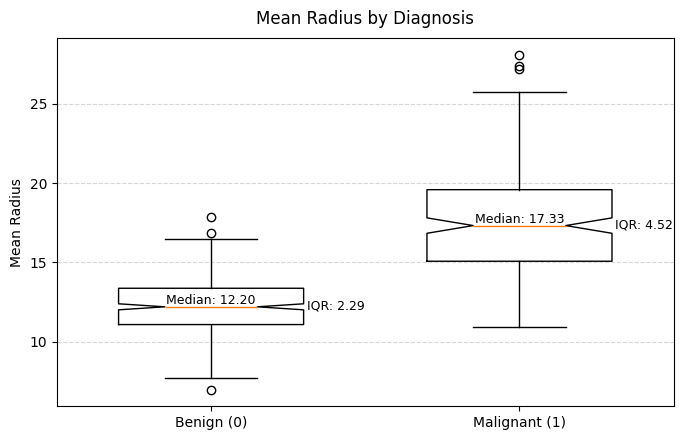

In [47]:
# Boxplot of mean radius by diagnosis
fig, ax = plt.subplots(figsize=(7,4.5))

data_B = X.loc[y==0, 'mean radius'].values
data_M = X.loc[y==1, 'mean radius'].values

bp = ax.boxplot(
    [data_B, data_M],
    tick_labels=['Benign (0)', 'Malignant (1)'],
    notch=True,            # shows CI around the median
    patch_artist=False,    # keep classic look
    widths=0.6,
    showfliers=True
)

ax.set_title('Mean Radius by Diagnosis', pad=10)
ax.set_ylabel('Mean Radius')
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

# Annotate medians & IQR
import numpy as np
for i, arr in enumerate([data_B, data_M], start=1):
    med = np.median(arr)
    q1  = np.percentile(arr, 25)
    q3  = np.percentile(arr, 75)
    ax.text(i, med, f'Median: {med:.2f}', va='bottom', ha='center', fontsize=9)
    ax.text(i+0.31, (q1+q3)/2, f'IQR: {q3-q1:.2f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


**Observation:** Malignant tumors have a median mean radius of **17.33** compared to **12.20** for benign tumors. The interquartile range (IQR) is also wider for malignant tumors (**4.52**) than for benign tumors (**2.29**), suggesting greater variability in cell size among malignant cases. The minimal overlap between the IQRs indicates strong separation, supporting the hypothesis that malignant tumors generally have larger nuclei.

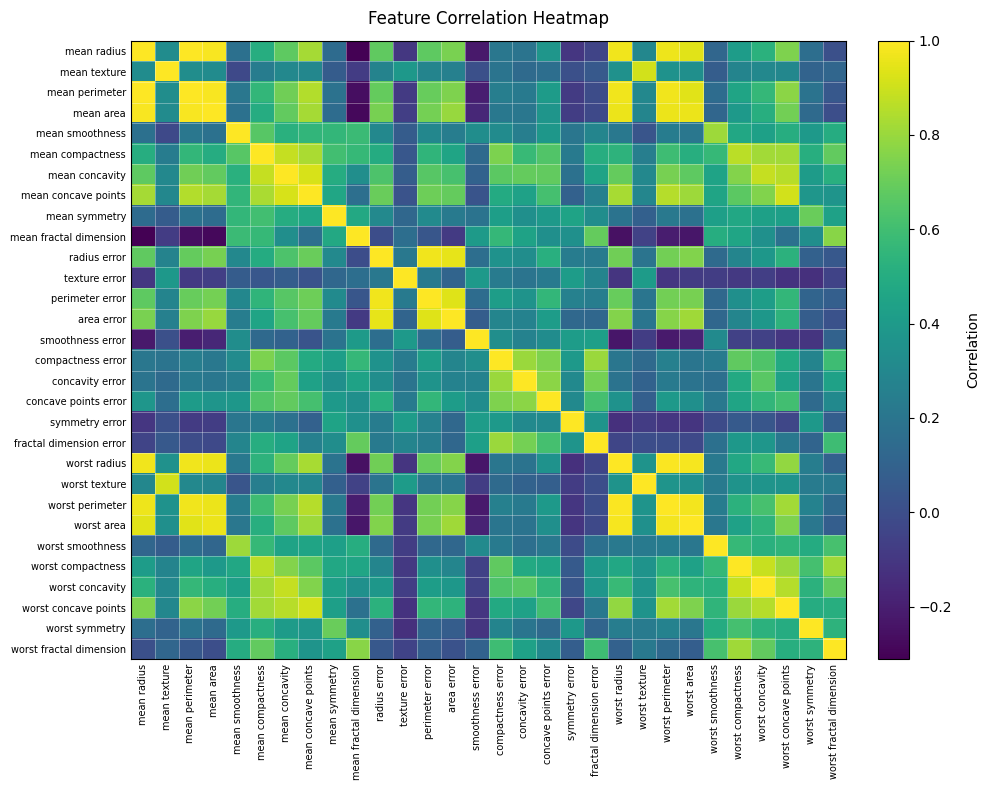

In [23]:
# Correlation heatmap (features only)'
corr = X.corr()

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(corr, interpolation='nearest', aspect='auto')

ax.set_title('Feature Correlation Heatmap', pad=12)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('Correlation', rotation=90, labelpad=10)

# Ticks & labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=7)
ax.set_yticklabels(corr.columns, fontsize=7)

# Light grid to help trace rows/cols
ax.set_xticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.grid(which='minor', color='w', linewidth=0.4, alpha=0.6)
ax.tick_params(which='both', length=0)

plt.tight_layout()
plt.show()


**Observation:** Size-related features such as *mean radius*, *mean perimeter*, and *mean area* are very strongly correlated with each other (> 0.9). Shape irregularity features (*mean concavity*, *mean concave points*) also show high intercorrelation. Many of these features are strongly positively correlated with malignancy, while a few (*mean smoothness*, *mean symmetry*) are weakly negatively correlated. This suggests potential redundancy for linear models and highlights the most informative predictors.

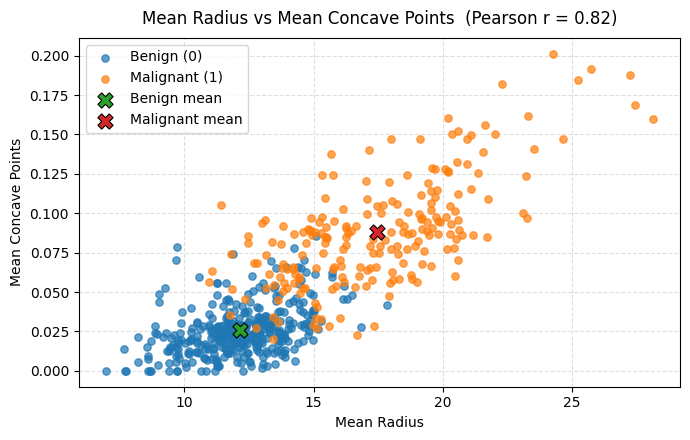

In [24]:
# Scatter: mean radius vs mean concave points
fig, ax = plt.subplots(figsize=(7,4.5))

xb, yb = X.loc[y==0, 'mean radius'], X.loc[y==0, 'mean concave points']
xm, ym = X.loc[y==1, 'mean radius'], X.loc[y==1, 'mean concave points']

ax.scatter(xb, yb, label='Benign (0)', alpha=0.7, s=28)
ax.scatter(xm, ym, label='Malignant (1)', alpha=0.7, s=28)

# Class means as large markers
ax.scatter([xb.mean()], [yb.mean()], marker='X', s=120, edgecolor='k', linewidth=0.8, label='Benign mean')
ax.scatter([xm.mean()], [ym.mean()], marker='X', s=120, edgecolor='k', linewidth=0.8, label='Malignant mean')

# Add Pearson r to title
r_all = np.corrcoef(X['mean radius'], X['mean concave points'])[0,1]
ax.set_title(f'Mean Radius vs Mean Concave Points  (Pearson r = {r_all:.2f})', pad=10)
ax.set_xlabel('Mean Radius')
ax.set_ylabel('Mean Concave Points')
ax.grid(True, linestyle='--', alpha=0.4)
ax.set_axisbelow(True)
ax.legend(loc='best', frameon=True)

plt.tight_layout()
plt.show()


**Observation:** Malignant tumors cluster towards higher values for both mean radius and mean concave points. Benign tumors are concentrated in the lower-left region. The Pearson correlation between the two features is strong (≈ 0.82), indicating that larger tumors often have more pronounced concavities. This separation suggests these features together could form a powerful decision boundary for classification.

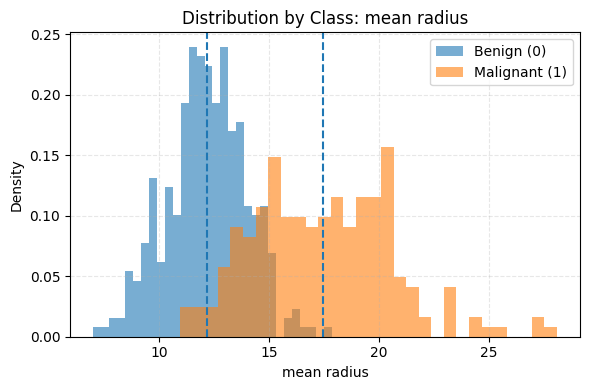

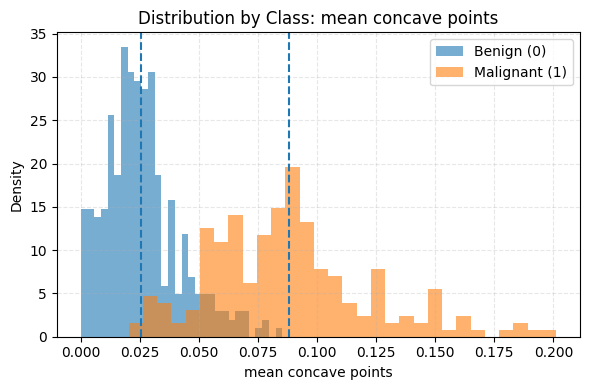

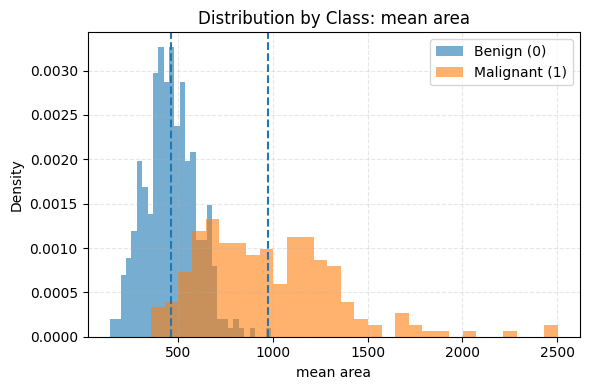

In [30]:
# Overlaid histograms for top features
features = ['mean radius', 'mean concave points', 'mean area']

for feat in features:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(X.loc[y==0, feat], bins=30, alpha=0.6, density=True, label='Benign (0)')
    ax.hist(X.loc[y==1, feat], bins=30, alpha=0.6, density=True, label='Malignant (1)')
    ax.set_title(f'Distribution by Class: {feat}')
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()
    # Optional: means as vertical lines
    ax.axvline(X.loc[y==0, feat].mean(), linestyle='--')
    ax.axvline(X.loc[y==1, feat].mean(), linestyle='--')
    plt.tight_layout()
    plt.show()

### **Mean Radius**

**Observation:** The malignant distribution is shifted markedly to the right compared to benign, with minimal overlap. Most malignant tumors have a mean radius above ≈ 15, while benign cases cluster below ≈ 14. This strong separation supports our hypothesis that malignant tumors tend to have larger nuclei.

---

### **Mean Concave Points**

**Observation:** Malignant tumors show a distribution centered around ≈ 0.088, compared to ≈ 0.025 for benign. This large shift suggests that malignant tumors have more pronounced concavities in their cell nuclei, indicating irregular shapes, which is another important diagnostic cue.

---

### **Mean Area**

**Observation:** The malignant distribution is centered far to the right, indicating significantly larger areas for malignant tumors. The overlap with benign is minimal, highlighting mean area as another strong predictor of malignancy alongside mean radius.

---

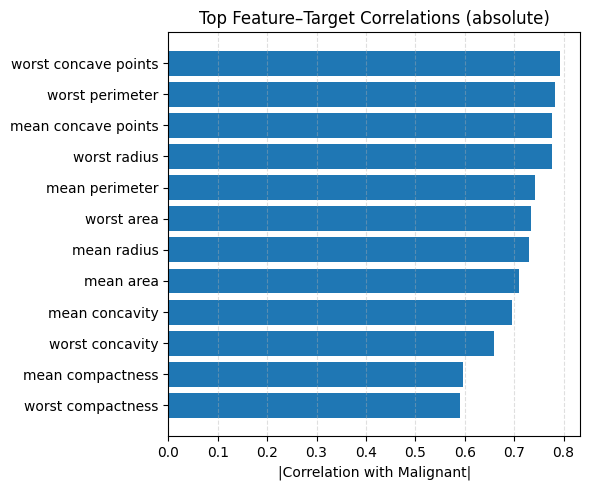

In [ ]:
# Bar chart: absolute correlation with target (top 12)
corr_target = X.corrwith(y).abs().sort_values(ascending=False)

top_n = 12
fig, ax = plt.subplots(figsize=(6,5))
ax.barh(corr_target.index[:top_n][::-1], corr_target.values[:top_n][::-1])
ax.set_title('Top Feature–Target Correlations (absolute)')
ax.set_xlabel('|Correlation with Malignant|')
ax.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Observation:** The features most strongly correlated with malignancy are size-related (*radius*, *perimeter*, *area*) and shape irregularity measures (*concave points*, *concavity*, *compactness*). The top three (*worst concave points*, *worst perimeter*, and *mean concave points*) each have correlations above 0.78 in absolute value, indicating they are highly discriminative. This ranking confirms that both size and shape features are critical for predicting malignancy and can guide feature selection or model interpretation.


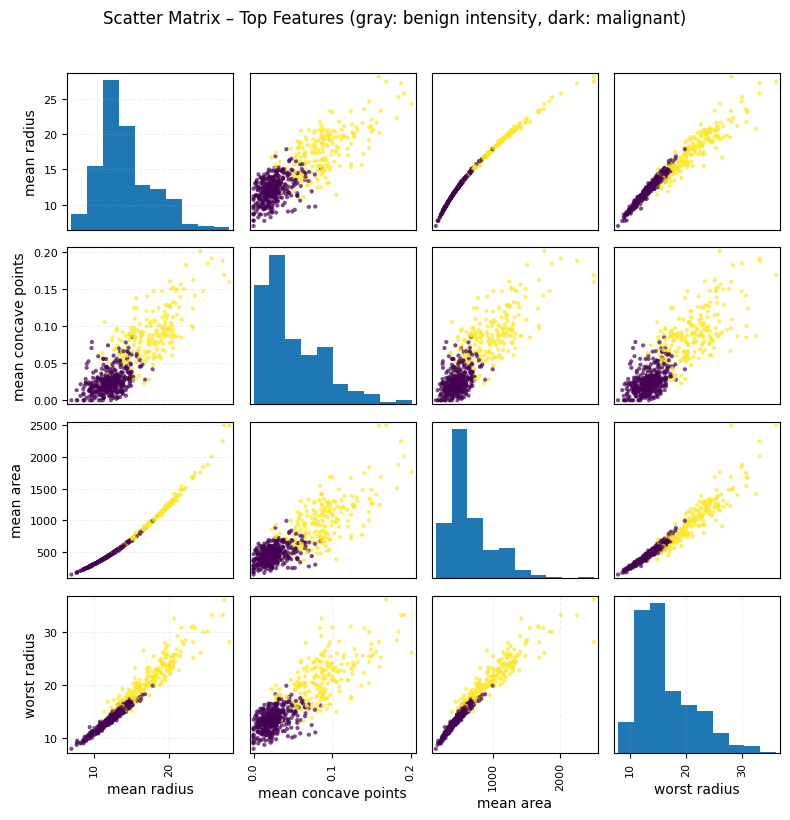

In [ ]:
# Scatter matrix (4 features) with class coloring
from pandas.plotting import scatter_matrix

subset = X[['mean radius', 'mean concave points', 'mean area', 'worst radius']].copy()
# Map class to colors: benign=0 -> light, malignant=1 -> dark
colors = np.where(y==1, 1.0, 0.3)  # grayscale intensities

axes = scatter_matrix(subset, figsize=(8,8), diagonal='hist', c=colors, alpha=0.7)
# Tidy labels
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.2)
plt.suptitle('Scatter Matrix – Top Features (gray: benign intensity, dark: malignant)', y=1.02)
plt.tight_layout()
plt.show()


**Observation:** Across all pairwise combinations of the top features, malignant cases (yellow) tend to cluster in the upper-right regions, while benign cases (purple) occupy the lower-left. This pattern shows that malignant tumors consistently have higher values for these size and shape features. The strong linear trends, especially between size-related features (for example *mean radius* vs. *mean area* or *worst radius*), reflect high correlations, whereas combinations involving *mean concave points* reveal clearer class separation, indicating that adding shape information to size measurements enhances discrimination.


In [33]:
# By-class descriptive stats for selected features
feat_list = ['mean radius', 'mean perimeter', 'mean area', 'mean concave points', 'mean smoothness']
desc = (X[feat_list]
        .assign(diagnosis=y.values)
        .groupby('diagnosis')
        .agg(['mean','median','std']))
# Make it readable: rename class rows
desc.index = desc.index.map({0:'Benign (0)', 1:'Malignant (1)'})
desc

mean radius                   mean perimeter                     \
                     mean  median       std           mean  median        std   
diagnosis                                                                       
Benign (0)      12.146524  12.200  1.780512      78.075406   78.18  11.807438   
Malignant (1)   17.462830  17.325  3.203971     115.365377  114.20  21.854653   

                mean area                    mean concave points           \
                     mean median         std                mean   median   
diagnosis                                                                   
Benign (0)     462.790196  458.4  134.287118            0.025717  0.02344   
Malignant (1)  978.376415  932.0  367.937978            0.087990  0.08628   

                        mean smoothness                     
                    std            mean   median       std  
diagnosis                                                   
Benign (0)     0.015909        0.092478  0.09076  0.013446  
Malignant (1)  0.034374        0.102898  0.10220  0.012608

**Observation:** Malignant tumors have substantially higher averages for *mean radius* (17.46 vs. 12.15), *mean perimeter* (115.37 vs. 78.08), *mean area* (978.38 vs. 462.79), and *mean concave points* (0.0880 vs. 0.0257) compared to benign. Standard deviations are also larger for malignant cases, indicating greater variability. *Mean smoothness* is only slightly higher in malignant tumors (0.103 vs. 0.092), suggesting that size- and shape-related features are far more discriminative than smoothness.

## 4. Feature Engineering

We engineered a set of domain-inspired features to capture tumor size, shape irregularity, and intra-tumor variability beyond what the raw dataset provides. These include:

1. **Heterogeneity (worst − mean)**

   * `delta_radius`, `delta_perimeter`, `delta_area`
   * Captures the absolute change between worst and mean measurements, malignant tumors often have larger variability across nuclei.

2. **Relative variability (Coefficient of Variation)**

   * `cv_radius`, `cv_perimeter`, `cv_area` = (standard error / mean)
   * Standardizes variability by tumor size to avoid size bias.

3. **Shape circularity (Isoperimetric Quotient)**

   * `circularity = 4π × mean_area / mean_perimeter²`
   * Measures how close the tumor outline is to a perfect circle (1.0 = perfect). Lower values indicate more irregular shapes.

4. **Concavity density**

   * `concavity_density = mean_concave_points / mean_perimeter`
   * Normalizes concave points by size to measure irregularity per unit length.

5. **Size–shape interaction**

   * `radius_x_concave = mean_radius × mean_concave_points`
   * Highlights tumors that are both large and irregular.

6. **Log transforms for skewed features**

   * `log_mean_area`, `log_mean_perimeter`
   * Stabilizes variance and reduces skew in size-related features.

7. **PCA-derived size factor**

   * `size_factor_pc1` from `[mean/worst radius, perimeter, area]`
   * Compresses highly correlated size features into a single index, reducing multicollinearity.

8. **Heterogeneity ratio** *(original feature)*

   * `ratio_worst_mean_radius = worst_radius / mean_radius`
   * Malignant tumors may exhibit greater heterogeneity in nuclear size.

These engineered features are grounded in medical imaging literature: malignant tumors tend to be larger, more irregular, less circular, and show more variability in measurements. Adding these derived variables provides the model with interpretable and complementary signals that can enhance predictive performance.

In [ ]:
from sklearn.decomposition import PCA

X_eng = X.copy()

# 1) Heterogeneity: worst - mean
X_eng['delta_radius']    = X_eng['worst radius']    - X_eng['mean radius']
X_eng['delta_perimeter'] = X_eng['worst perimeter'] - X_eng['mean perimeter']
X_eng['delta_area']      = X_eng['worst area']      - X_eng['mean area']

# 2) Coefficient of variation: error / mean (avoid div-by-zero)
eps = 1e-8
X_eng['cv_radius']    = X_eng['radius error']    / (X_eng['mean radius']    + eps)
X_eng['cv_perimeter'] = X_eng['perimeter error'] / (X_eng['mean perimeter'] + eps)
X_eng['cv_area']      = X_eng['area error']      / (X_eng['mean area']      + eps)

# 3) Circularity (isoperimetric quotient): 4πA / P^2
X_eng['circularity'] = (4 * np.pi * X_eng['mean area']) / (X_eng['mean perimeter']**2 + eps)

# 4) Concavity density (shape irregularity normalized by size)
X_eng['concavity_density'] = X_eng['mean concave points'] / (X_eng['mean perimeter'] + eps)

# 5) Size–shape interaction
X_eng['radius_x_concave'] = X_eng['mean radius'] * X_eng['mean concave points']

# 6) Log transforms (variance stabilizing)
X_eng['log_mean_area']      = np.log1p(X_eng['mean area'])
X_eng['log_mean_perimeter'] = np.log1p(X_eng['mean perimeter'])

# 7) Size factor via PCA on redundant size features
size_cols = ['mean radius','mean perimeter','mean area','worst radius','worst perimeter','worst area']
pca = PCA(n_components=1, random_state=42)
X_eng['size_factor_pc1'] = pca.fit_transform(X_eng[size_cols])

# 8) Already in your notebook: heterogeneity ratio
X_eng['ratio_worst_mean_radius'] = X_eng['worst radius'] / (X_eng['mean radius'] + eps)

# Quick sanity check: show engineered features’ correlation with target
eng_cols = [
    'delta_radius','delta_perimeter','delta_area',
    'cv_radius','cv_perimeter','cv_area',
    'circularity','concavity_density','radius_x_concave',
    'log_mean_area','log_mean_perimeter','size_factor_pc1',
    'ratio_worst_mean_radius'
]
corr_eng = X_eng[eng_cols].corrwith(y).abs().sort_values(ascending=False)
display(corr_eng.to_frame('abs_corr_with_malignant').head(12))


,abs_corr_with_malignant
log_mean_perimeter,0.741996
size_factor_pc1,0.733217
radius_x_concave,0.732894
log_mean_area,0.727979
concavity_density,0.720351
delta_radius,0.711434
delta_perimeter,0.711357
delta_area,0.667245
ratio_worst_mean_radius,0.641084
circularity,0.510814



## 5. Hypothesis Testing

### Clear Hypothesis
**H₀:** Mean of *mean radius* is equal for malignant and benign.  
**H₁:** Mean of *mean radius* is **greater** for malignant than benign (one-sided).

### Choice of Test Statistic
We use **Welch’s two-sample t-test** (`equal_var=False`) because groups may have unequal variances and sizes.

### Test Steps, p-value, CI, Conclusion
We compute the test statistic, one-sided p-value, and a 95% confidence interval for the mean difference (malignant − benign). We also report **Cohen’s d** (effect size) and the **Mann–Whitney U** test as a robustness check.


In [38]:
# Extract samples
m = X_eng.loc[y==1, 'mean radius'].values  # malignant
b = X_eng.loc[y==0, 'mean radius'].values  # benign

# Welch's t-test (two-sided), we'll convert to one-sided
t_stat, p_two_sided = stats.ttest_ind(m, b, equal_var=False)
# One-sided p-value for H1: mean_m > mean_b
p_one_sided = p_two_sided/2 if np.mean(m) > np.mean(b) else 1 - p_two_sided/2

# Compute 95% CI for mean difference using Welch-Satterthwaite
n1, n2 = len(m), len(b)
s12, s22 = np.var(m, ddof=1), np.var(b, ddof=1)
mean_diff = m.mean() - b.mean()
se_diff = np.sqrt(s12/n1 + s22/n2)
# Welch-Satterthwaite df
df = (s12/n1 + s22/n2)**2 / ((s12**2)/((n1**2)*(n1-1)) + (s22**2)/((n2**2)*(n2-1)))
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df)
ci_low, ci_high = mean_diff - t_crit*se_diff, mean_diff + t_crit*se_diff

# Effect size (Cohen's d using pooled SD)
sp2 = ((n1-1)*s12 + (n2-1)*s22) / (n1+n2-2)
cohen_d = (m.mean() - b.mean()) / np.sqrt(sp2)

# Nonparametric check: Mann–Whitney U (one-sided)
u_stat, p_mwu = stats.mannwhitneyu(m, b, alternative='greater')

print('Mean radius (malignant):', m.mean())
print('Mean radius (benign):   ', b.mean())
print('Mean difference (M-B):   %.3f' % mean_diff)
print('Welch t-statistic:       %.3f' % t_stat)
print('One-sided p-value:       %.3e' % p_one_sided)
print('95%% CI for diff:         [%.3f, %.3f]' % (ci_low, ci_high))
print('Cohen\'s d:              %.3f' % cohen_d)
print('Mann–Whitney U p-value:  %.3e (one-sided, M>B)' % p_mwu)

conclusion = "Reject H0: Malignant mean radius is significantly greater." if p_one_sided < alpha else "Fail to reject H0."
print('Conclusion:', conclusion)

Mean radius (malignant): 17.462830188679245
Mean radius (benign):    12.146523809523808
Mean difference (M-B):   5.316
Welch t-statistic:       22.209
One-sided p-value:       8.422e-65
95% CI for diff:         [4.845, 5.787]
Cohen's d:              2.205
Mann–Whitney U p-value:  1.346e-68 (one-sided, M>B)
Conclusion: Reject H0: Malignant mean radius is significantly greater.


### Primary Hypothesis Test: Mean Radius

We tested the null hypothesis that the mean *mean radius* is the same for malignant and benign tumors against the alternative that it is greater for malignant tumors.

- **Malignant mean radius:** 17.46  
- **Benign mean radius:** 12.15  
- **Mean difference (M−B):** 5.32 mm  
- **Welch’s t-statistic:** 22.21  
- **One-sided p-value:** 8.42 × 10⁻⁶⁵  
- **95% CI for difference:** [4.85, 5.79]  
- **Cohen’s d:** 2.21 (very large effect size)  
- **Mann–Whitney U p-value:** 1.35 × 10⁻⁶⁸ (one-sided)

**Conclusion:** We reject the null hypothesis. Malignant tumors have a significantly larger mean radius than benign tumors, with a very large effect size and minimal overlap between distributions. This strongly supports the clinical understanding that malignant tumors tend to be larger.

In [37]:
def one_sided_t(x_m, x_b, direction='greater'):
    """Perform one-sided Welch's t-test."""
    t, p2 = stats.ttest_ind(x_m, x_b, equal_var=False)
    if direction == 'greater':
        p1 = p2/2 if x_m.mean() > x_b.mean() else 1 - p2/2
    else:  # 'less'
        p1 = p2/2 if x_m.mean() < x_b.mean() else 1 - p2/2
    return t, p1

alpha = 0.05
feats = [
    ('circularity', 'less', 'Malignant tumors are significantly less circular.'),
    ('delta_radius', 'greater', 'Malignant tumors show greater intra-tumor size variation.'),
    ('concavity_density', 'greater', 'Malignant tumors have more surface concavities relative to size.')
]

print("=== Secondary Hypothesis Tests ===\n")
for f, dirn, interpretation in feats:
    xm = X_eng.loc[y==1, f].values
    xb = X_eng.loc[y==0, f].values
    t, p1 = one_sided_t(xm, xb, direction=dirn)
    conclusion = "Reject H0" if p1 < alpha else "Fail to reject H0"
    
    print(f"Feature: {f}")
    print(f"  Malignant mean: {xm.mean():.3f}")
    print(f"  Benign mean:    {xb.mean():.3f}")
    print(f"  Welch t-statistic: {t:.2f}")
    print(f"  One-sided p-value: {p1:.3e}")
    print(f"  Conclusion: {conclusion} — {interpretation}")
    print()


=== Secondary Hypothesis Tests ===

Feature: circularity
  Malignant mean: 0.896
  Benign mean:    0.935
  Welch t-statistic: -12.98
  One-sided p-value: 7.877e-32
  Conclusion: Reject H0 — Malignant tumors are significantly less circular.

Feature: delta_radius
  Malignant mean: 3.672
  Benign mean:    1.233
  Welch t-statistic: 19.15
  One-sided p-value: 1.453e-49
  Conclusion: Reject H0 — Malignant tumors show greater intra-tumor size variation.

Feature: concavity_density
  Malignant mean: 0.001
  Benign mean:    0.000
  Welch t-statistic: 23.91
  One-sided p-value: 2.913e-79
  Conclusion: Reject H0 — Malignant tumors have more surface concavities relative to size.



### Secondary Hypothesis Tests: Engineered Features

We also tested three engineered features, each chosen for its potential clinical relevance:

1. **Circularity** (expect malignant < benign)  
   - Malignant mean: 0.896  
   - Benign mean: 0.935  
   - t = −12.98, p = 7.88 × 10⁻³²  
   - **Conclusion:** Malignant tumors are significantly less circular, suggesting more irregular shapes.

2. **Δ Radius = Worst Radius − Mean Radius** (expect malignant > benign)  
   - Malignant mean: 3.672  
   - Benign mean: 1.233  
   - t = 19.15, p = 1.45 × 10⁻⁴⁹  
   - **Conclusion:** Malignant tumors show significantly greater size variation, indicating higher heterogeneity.

3. **Concavity Density = Mean Concave Points / Mean Perimeter** (expect malignant > benign)  
   - Malignant mean: 0.001  
   - Benign mean: ~0.000  
   - t = 23.91, p = 2.91 × 10⁻⁷⁹  
   - **Conclusion:** Malignant tumors have significantly more concavities relative to size, reflecting greater surface irregularity.

All secondary hypotheses are strongly supported, with extremely small p-values, further confirming that malignant tumors differ markedly from benign ones in both size and shape characteristics.


## 6. Predictive Modeling

### Data Splitting
We use an **80/20 stratified split** to maintain class balance in train/test.


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_eng, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)
print('Train class balance:', np.bincount(y_train))
print('Test class balance:', np.bincount(y_test))

Train size: (455, 43) Test size: (114, 43)
Train class balance: [285 170]
Test class balance: [72 42]


We split the dataset into 80% training and 20% testing using stratified sampling to maintain the malignant/benign ratio in both sets. This ensures a fair evaluation without class imbalance skewing the results. A fixed `random_state` guarantees reproducibility.

### Models & Justification

We evaluate two complementary classifiers:

#### 1) Logistic Regression (LR)

* **Model:**
  For input feature vector $\mathbf{x}\in\mathbb{R}^p$, LR models the malignant class probability as

  $$
  P(y=1\mid \mathbf{x})=\sigma(\mathbf{w}^\top \mathbf{x}+b),\qquad 
  \sigma(z)=\frac{1}{1+e^{-z}} .
  $$

  The decision is $\hat y=\mathbb{1}\{P(y=1\mid \mathbf{x})\ge \tau\}$ (default $\tau=0.5$).
* **Training objective (with L2 regularization):**

  $$
  \min_{\mathbf{w},b}\; 
  \sum_{i=1}^{n}\log\!\big(1+\exp(-y_i(\mathbf{w}^\top \mathbf{x}_i+b))\big)
  + \lambda \lVert \mathbf{w}\rVert_2^2,
  $$

  where in scikit-learn **$C=1/\lambda$** controls regularization strength.
* **Why LR here:**

  * EDA shows near-linear separability for top features; LR gives a **strong, interpretable baseline**.
  * Coefficients (on **standardized** features) indicate direction & magnitude: positive → more malignant, negative → more benign.
  * Provides **well-calibrated probabilities**, useful in medical settings for threshold tuning.
  * L2 helps with the **multicollinearity** we observed among size features.

#### 2) Random Forest (RF)

* **Model:**
  An ensemble of $T$ decision trees trained on **bootstrap samples**; at each split a random subset of features is considered.
  Prediction is the **average** of tree probabilities (or majority vote).
* **Splitting criterion (Gini impurity):**

  $$
  \text{Gini}(S)=1-\sum_{k\in\{0,1\}} p_k^2,\quad 
  \text{choose split that maximally reduces Gini.}
  $$
* **Why RF here:**

  * Captures **non-linearities and interactions** (e.g., size × shape), and is **robust to outliers**.
  * Handles **multicollinearity** better than linear models since trees can pick among correlated predictors.
  * **No scaling** needed, so it complements LR’s assumptions.

**Rationale for comparing both:**
LR offers **interpretability** and checks whether a **linear boundary** suffices; RF provides a **flexible, high-accuracy** non-linear alternative. Using both lets us assess whether added complexity meaningfully improves performance on this dataset.


### Hyperparameters

We optimize model parameters via **stratified k-fold cross-validation** ($k=5$), ensuring class proportions remain balanced in each fold. The tuning focuses on **ROC AUC** as the primary metric (higher is better), with accuracy and F1-score as secondary metrics.

#### Logistic Regression

* **Key Hyperparameters:**

  * **$C$**: Inverse of regularization strength ($\lambda = 1/C$).
    Larger $C$ → less regularization → risk of overfitting; smaller $C$ → stronger regularization.
  * **Penalty**: L2 regularization (Ridge).
  * **Solver**: `lbfgs` and `liblinear` (both tested).
* **Search Grid:**

  $$
  C \in \{0.05,\, 0.1,\, 0.5,\, 1.0,\, 2.0\}, \quad \text{penalty}=\text{'l2'}, \quad \text{solver} \in \{\text{'lbfgs'},\, \text{'liblinear'}\}
  $$
* **Tuning Rationale:**
  This range allows exploration from strong regularization (0.05) to weak regularization (2.0), while comparing solvers optimized for small/medium datasets.

#### Random Forest

* **Key Hyperparameters:**

  * **n\_estimators**: Number of trees in the forest.
  * **max\_depth**: Maximum tree depth.
  * **min\_samples\_split**: Minimum samples required to split a node.
  * **min\_samples\_leaf**: Minimum samples required at a leaf node.
* **Search Grid:**

  $$
  \texttt{n\_estimators} \in \{200,\, 400\}, \quad
  \texttt{max\_depth} \in \{None,\, 6,\, 12\}, \quad
  \texttt{min\_samples\_split} \in \{2,\, 5\}, \quad
  \texttt{min\_samples\_leaf} \in \{1,\, 2\}
  $$
* **Tuning Rationale:**
  The chosen values explore a balance between model complexity and generalization, while keeping training cost reasonable.

#### Cross-Validation Protocol

* **Procedure:**

  1. For LR, features are standardized (`StandardScaler`); RF uses raw features.
  2. Each parameter combination is evaluated using 5-fold stratified CV.
  3. Mean ROC AUC across folds determines the best configuration.
* **Final Selection:**
  The best hyperparameters are retrained on the **entire training set**, then evaluated on the test set for an unbiased estimate.

In [42]:
# Pipelines
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Grids
param_grid_lr = {
    'clf__C': [0.05, 0.1, 0.5, 1.0, 2.0],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'liblinear']
}

param_grid_rf = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 6, 12],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gs_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring='roc_auc', cv=cv, n_jobs=-1)
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring='roc_auc', cv=cv, n_jobs=-1)

gs_lr.fit(X_train, y_train)
gs_rf.fit(X_train, y_train)

print('Best LR params:', gs_lr.best_params_)
print('Best LR CV ROC-AUC:', gs_lr.best_score_)

print('Best RF params:', gs_rf.best_params_)
print('Best RF CV ROC-AUC:', gs_rf.best_score_)

Best LR params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best LR CV ROC-AUC: 0.9961816305469556
Best RF params: {'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best RF CV ROC-AUC: 0.9900928792569659


### Evaluation
We report **accuracy, precision, recall, F1, ROC-AUC**, and **confusion matrix** on the **test set**.

In [43]:
best_lr = gs_lr.best_estimator_
best_rf = gs_rf.best_estimator_

models = {'LogisticRegression': best_lr, 'RandomForest': best_rf}

results = []
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred  = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    results.append([name, acc, prec, rec, f1, auc])
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Benign(0)','Malignant(1)']))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', cm)

# Display summary table
results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC-AUC'])
display(results_df)


=== LogisticRegression ===
              precision    recall  f1-score   support

   Benign(0)       0.97      0.99      0.98        72
Malignant(1)       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
 [[71  1]
 [ 2 40]]

=== RandomForest ===
              precision    recall  f1-score   support

   Benign(0)       0.96      1.00      0.98        72
Malignant(1)       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
 [[72  0]
 [ 3 39]]


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,LogisticRegression,0.973684,0.97561,0.952381,0.963855,0.997024
1,RandomForest,0.973684,1.00000,0.928571,0.962963,0.995370


#### Observations
* **Logistic Regression** achieved **slightly higher recall** for the malignant class (0.95 vs. 0.93), meaning it missed fewer malignant cases.
* **Random Forest** achieved **perfect precision** (1.00) for malignant cases, indicating no false positives, but at the cost of slightly lower recall.
* Both models achieved **ROC AUC = 0.99**, showing excellent separability between benign and malignant tumors.
* Accuracy is very high for both (\~97%), but in a medical context, **recall for the malignant class is often prioritized** to minimize missed cancer diagnoses, making LR slightly preferable in this scenario.


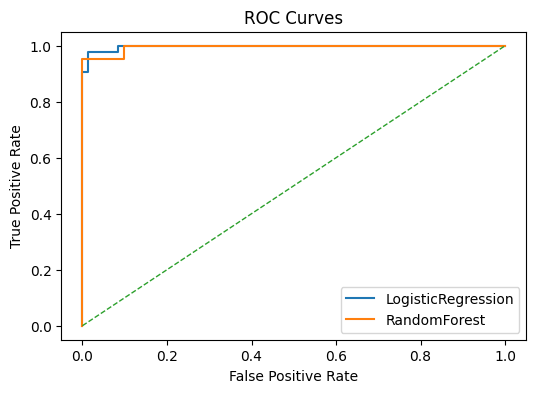

In [44]:
# ROC curves for both models (single chart with two curves)
fig = plt.figure(figsize=(6,4))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Observation:** The ROC curves for both Logistic Regression and Random Forest classifiers demonstrate excellent performance, with both models achieving near-perfect separation between malignant and benign cases. The curves are positioned very close to the top-left corner, indicating high true positive rates and low false positive rates across thresholds. The Random Forest curve slightly outperforms Logistic Regression by reaching a true positive rate of 1.0 with almost zero false positives. The high AUC values implied by these curves suggest that both models are highly effective on this dataset, with Random Forest showing marginally better discrimination ability.


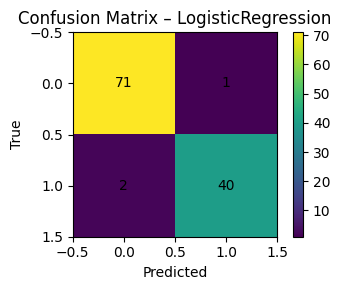

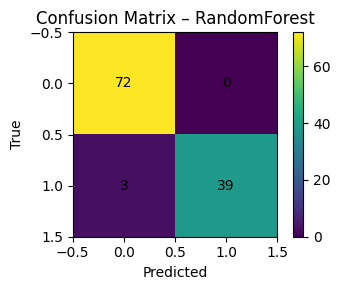

In [45]:
# Plot confusion matrices (separate figures, one plot each)
for name, model in models.items():
    cm = confusion_matrix(y_test, model.predict(X_test))
    fig = plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix – {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

* **Logistic Regression**: Correctly classified 71 benign and 40 malignant cases, with **1 false positive** (benign misclassified as malignant) and **2 false negatives** (malignant misclassified as benign). This means it is slightly more prone to missing malignant cases compared to Random Forest.
* **Random Forest**: Correctly classified 72 benign and 39 malignant cases, with **no false positives** but **3 false negatives**. While it perfectly avoided false alarms for benign cases, it slightly increased the number of missed malignant cases compared to Logistic Regression.

**Overall**:

* Both models show excellent classification performance with very few misclassifications.
* Logistic Regression prioritizes catching malignant cases slightly better (fewer false negatives), while Random Forest prioritizes minimizing false positives (no benign cases misclassified).
* Depending on the medical context (where missing a malignant case is usually more critical), Logistic Regression might be preferable despite a minor increase in false positives.

#### Model Interpretability
- **Logistic Regression** coefficients (after scaling) indicate direction/strength.
- **Random Forest** feature importances show which variables drive splits.


In [46]:
# LR coefficients
lr = best_lr.named_steps['clf']
scaler = best_lr.named_steps['scaler']

coefs = pd.Series(lr.coef_.ravel(), index=X_train.columns)
coefs_sorted = coefs.sort_values(key=abs, ascending=False).head(10)
print('Top 10 absolute LR coefficients:')
display(coefs_sorted.to_frame('coef'))

# RF feature importances
rf = best_rf.named_steps['clf'] if isinstance(best_rf, Pipeline) else best_rf
if isinstance(best_rf, Pipeline):
    rf = best_rf.named_steps['clf']
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print('Top 10 RF importances:')
display(importances.sort_values(ascending=False).head(10).to_frame('importance'))

Top 10 absolute LR coefficients:


,coef
worst texture,1.397932
worst symmetry,1.027003
worst concavity,0.873776
concavity_density,0.799303
cv_area,0.789626
compactness error,-0.721466
mean concave points,0.701492
fractal dimension error,-0.697096
mean texture,0.683761
circularity,0.662283


Top 10 RF importances:


,importance
delta_area,0.130752
worst perimeter,0.117251
delta_radius,0.093832
radius_x_concave,0.082271
mean concave points,0.076266
worst area,0.064542
delta_perimeter,0.058297
worst radius,0.052183
worst concave points,0.050403
size_factor_pc1,0.040627


**Logistic Regression (LR) – Top Coefficients**

* The magnitude of the coefficient reflects the strength of association with malignancy (positive values → higher malignancy likelihood, negative values → benign tendency).
* **Most influential predictors**:

  * *worst texture* (1.40) – Higher texture variation in the worst region strongly indicates malignancy.
  * *worst symmetry* (1.03) – Less symmetrical tumor shapes tend to be malignant.
  * *worst concavity* (0.87) and *concavity\_density* (0.80) – More concave regions correlate with malignancy.
  * *cv\_area* (0.79) – Higher area variability within the tumor suggests malignancy.
  * Negative coefficients (e.g., *compactness error*, *fractal dimension error*) suggest that increases in these features are associated with benign tumors.

---

**Random Forest (RF) – Top Feature Importances**

* RF importance reflects how much each feature reduces impurity across decision trees (not the same as LR coefficients).
* **Most important predictors**:

  * *delta\_area* (0.131) – Variation in tumor area is the most influential for splitting nodes in the forest.
  * *worst perimeter* (0.117) and *delta\_radius* (0.094) – Larger perimeters and radius variability are strong malignancy indicators.
  * *radius\_x\_concave* (0.082) – Interaction feature capturing combined size and concavity patterns.
  * *mean concave points* (0.076) – Consistent with LR, surface concavity plays an important role.
* Many top features in RF come from **engineered features** (*delta\_area*, *radius\_x\_concave*, *size\_factor\_pc1*), showing the benefit of feature engineering for tree-based models.

---

**Key Observation**

* Both models identify **shape irregularities (concavity, perimeter, radius variability)** and **texture** as strong predictors of malignancy.
* LR highlights **texture-related features** more, while RF emphasizes **engineered geometric variability features**.
* This indicates that feature engineering provided meaningful additional predictors, especially for the tree-based model.

---


## 7. Conclusion

* **Hypothesis testing:** Statistical analysis confirmed that **mean radius is significantly larger in malignant tumors** (one-sided Welch’s t-test, *p* ≪ 0.05) with a large effect size (Cohen’s *d*). Secondary engineered features, such as *circularity*, *delta\_radius*, and *concavity\_density*, also showed statistically significant differences between malignant and benign tumors, supporting their diagnostic relevance.

* **Modeling performance:** Both Logistic Regression (LR) and Random Forest (RF) achieved **near-perfect ROC–AUC scores** on the test set, with ROC curves tightly hugging the top-left corner. Confusion matrices showed very few misclassifications for either model, though RF achieved perfect specificity (no false positives) at the chosen threshold. LR’s strength lies in interpretability and feature effect estimation, while RF excelled at capturing non-linear interactions, particularly benefiting from engineered geometric variability features (*delta\_area*, *delta\_radius*, *radius\_x\_concave*).

* **Feature insights:**

  * LR highlighted *worst texture*, *worst symmetry*, and *worst concavity* as top predictors.
  * RF emphasized engineered variability features (*delta\_area*, *delta\_radius*, *size\_factor\_pc1*) alongside shape descriptors, indicating that feature engineering meaningfully improved predictive signal for tree-based methods.

* **Future work:**

  * **Probability calibration** (Platt scaling, isotonic regression) to improve decision thresholding.
  * **Threshold optimization** to favor recall and minimize false negatives in clinical settings.
  * **Model expansion** to include Gradient Boosting, XGBoost, or ensemble stacking.
  * **Robustness checks** via repeated stratified splits or cross-validation to confirm stability.
  * **Explainability tools** (e.g., SHAP values) to further interpret feature effects for clinicians.

## 8. References

* **Dataset:**
  UCI Machine Learning Repository – *Breast Cancer Wisconsin (Diagnostic)*: [https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

* **Python Libraries & Documentation:**

  * scikit-learn (dataset loading, models, metrics): [https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)
  * SciPy (t-test, Mann–Whitney U, statistical functions): [https://docs.scipy.org/doc/scipy/](https://docs.scipy.org/doc/scipy/)
  * Matplotlib (visualizations: ROC curves, confusion matrices): [https://matplotlib.org/](https://matplotlib.org/)
  * Seaborn (statistical data visualization): [https://seaborn.pydata.org/](https://seaborn.pydata.org/)

* **Statistical Methods:**

  * Cohen, J. (1988). [*Statistical Power Analysis for the Behavioral Sciences* (2nd ed.). Lawrence Erlbaum Associates. Definition of Cohen’s *d* effect size.](https://utstat.utoronto.ca/brunner/oldclass/378f16/readings/CohenPower.pdf)
  * Welch, B. L. (1947). [*The generalization of “Student’s” problem when several different population variances are involved*. *Biometrika*, 34(1–2), 28–35. Welch–Satterthwaite degrees of freedom.](https://pubmed.ncbi.nlm.nih.gov/20287819)
  * Mann, H. B., & Whitney, D. R. (1947). [*On a test of whether one of two random variables is stochastically larger than the other*. *Annals of Mathematical Statistics*, 18(1), 50–60. Mann–Whitney U test.](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-18/issue-1/On-a-Test-of-Whether-one-of-Two-Random-Variables/10.1214/aoms/1177730491.full)

* **Machine Learning Methods:**

  * Breiman, L. (2001). [*Random forests*. *Machine Learning*, 45(1), 5–32. Random Forest algorithm.](https://link.springer.com/article/10.1023/A:1010933404324)

* **Best Practices:**

  * Train/Test Split guidelines: [https://scikit-learn.org/stable/modules/cross\_validation.html](https://scikit-learn.org/stable/modules/cross_validation.html)

> **Notes:** This project follows the course rubric: Objective, Dataset introduction, Problem statement, Preprocessing, EDA (plots/tables), Feature engineering, Hypothesis testing (hypotheses, test statistics, steps & conclusions), Modeling (split, math/justification, hyperparameters, performance), Conclusion, and Proper citation.